`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

In [1]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
warnings.filterwarnings("ignore")

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [3]:
# the issue with my dict creation is i had aggregated as false when it should be true
# variables = ['dissic','talk','so','thetao']
# cat = col.search(source_id = ['E3SM-1-1','GFDL-ESM4','NorCPM1',
#                               'CESM2-FV2','CESM2','MRI-ESM2-0',
#                               'CESM2-WACCM-FV2','GFDL-CM4','CESM2-WACCM',
#                               'E3SM-1-0','E3SM-1-1-ECA'], variable_id= variables,experiment_id= 'historical', table_id = ['Omon'], grid_label = ['gn', 'gr'])
# dd = cat.to_dataset_dict(
#     zarr_kwargs={'consolidated': True, 'use_cftime':True},
#     storage_options={'token': 'anon'},
#     preprocess=combined_preprocessing,
#     aggregate=False)
# # variable_id= ['so', 'thetao', 'dissic', 'talk']



variables = ['dissic','talk','so','thetao']
z_kwargs = {'consolidated': True, 'decode_times':False}
query = dict(experiment_id=['historical'], table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
             source_id=['GFDL-ESM4',
                        'CESM2-FV2','CESM2','MRI-ESM2-0',
                        'CESM2-WACCM-FV2','GFDL-CM4','CESM2-WACCM',
                        'E3SM-1-1-ECA'])
cat = col.search(**query)
# print(cat.df['source_id'].unique())
dset_dict = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},preprocess=combined_preprocessing)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [4]:
temp={}
for name,item in dset_dict.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=dset_dict[name]
dset_dict = temp
dset_dict

{'CMIP.NOAA-GFDL.GFDL-CM4.historical.Omon.gr': <xarray.Dataset>
 Dimensions:      (bnds: 2, lev: 35, member_id: 1, time: 1980, x: 360, y: 180)
 Coordinates:
   * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
     lat_bounds   (y, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
   * lev          (lev) float64 2.5 10.0 20.0 32.5 ... 5.5e+03 6e+03 6.5e+03
     lev_bounds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
   * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
     lon_bounds   (x, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
   * time         (time) int64 0 708 1416 2148 ... 1443192 1443924 1444656
     time_bounds  (time, bnds) float64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
   * bnds         (bnds) int64 0 1
     lon          (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
     lat          (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89

### Error in aggregation for 3 models
> `'E3SM-1-1'`

> `'E3SM-1-0'`

> `'No

In [31]:
#variables = ['dissic','talk','so','thetao']
z2_kwargs = {'consolidated': True, 'decode_times':False}
query2 = dict(experiment_id=['historical'], table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
             source_id=['E3SM-1-1','E3SM-1-0','NorCPM1'])
cat2 = col.search(**query2)
# print(cat.df['source_id'].unique())
dset_dict2 = cat2.to_dataset_dict(zarr_kwargs=z2_kwargs, storage_options={'token': 'anon'},preprocess=combined_preprocessing)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


AggregationError: 
        Failed to join/concatenate datasets in group with key=CMIP.E3SM-Project.E3SM-1-0.historical.Omon.gr along a new dimension `member_id`.

        *** Arguments passed to xarray.concat() ***:

        - objs: a list of 5 datasets
        - dim: <xarray.DataArray 'member_id' (member_id: 5)>
array(['r1i1p1f1', 'r2i1p1f1', 'r4i1p1f1', 'r3i1p1f1', 'r5i1p1f1'],
      dtype='<U8')
Dimensions without coordinates: member_id
        - data_vars: ['so']
        - and kwargs: {'coords': 'minimal', 'compat': 'override'}

        ********************************************
        

This is copied from Graeme's code https://github.com/gmacgilchrist/cmip6/blob/74522b1593a3cac6174ec4e4ddcf6645204a7a86/dev_cmip6.ipynb

It needs some changes-`temperature_in`, `temperature_out`, `pressure_in`, and `pressure_out`.

rho_seawater = 1035 kg/m^3

In [32]:
def calc_PpCO2_graeme(ds):
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,pressure=0)
    return ds['talk'].copy(data=results['pCO2'])

`results = pyco2.sys(par1=None, par2=None, par1_type=None, par2_type=None, **kwargs)`

### Arguments

`par1` and `par2`: values of two different carbonate system parameters.

`par1_type` and `par2_type`: which types of parameter par1 and par2 are.


Total alkalinity (type `1`) in μmol·kg−1.
> <font color='red'>alkalinity in CMIP6 is in mol/m3 </font> 

Dissolved inorganic carbon (type `2`) in μmol·kg−1.
> <font color='red'>DIC in CMIP6 is in mol/m3 </font> 

pH (type `3`) on the Total, Seawater, Free or NBS scale1. Which scale is given by the argument opt_pH_scale.

Partial pressure of CO2 (type `4`) in μatm, Fugacity of CO2 (type `5`) in μatm, Aqueous CO2 (type `8`) in μmol·kg−1, or Dry mole fraction of CO2 (type `9`) in ppm.

Carbonate ion (type `6`) in μmol·kg−1.

Bicarbonate ion (type `7`) in μmol·kg−1.

### Kwargs/hydrographic conditions

`salinity`: practical salinity (dimensionless).

`temperature`: temperature at which `par1` and `par2` arguments are provided in °C (default 25 °C).
> <font color='red'>in situ temp </font> 
> `gsw.t_from_CT(SA, CT, p)`

`pressure`: water pressure at which `par1` and `par2` arguments are provided in dbar (default 0 dbar).
> pressure_in will be related to depth

> `gsw.p_from_z(z, lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)` = dbar

> > Parameters

> > > zarray-like: Depth, positive up, m

> > > latarray-like: Latitude, -90 to 90 degrees

> > > geo_strf_dyn_heightarray-like

> > > > dynamic height anomaly, m^2/s^2

> > > > Note that the reference pressure, p_ref, of geo_strf_dyn_height must be zero (0) dbar.

> > > sea_surface_geopotentialarray-like

> > > > geopotential at zero sea pressure, m^2/s^2

> > Returns

> > > parray-like, dbar

> > > > sea pressure ( i.e. absolute pressure - 10.1325 dbar )


`temperature_out`: temperature at which results will be calculated in °C ("output conditions").
> <font color='red'>temperature_out = thetao (potential temp) </font> 

`pressure_out`: water pressure at which results will be calculated in dbar ("output conditions").
> <font color='red'>pressure out should be 0 since raised to surface </font> 

### Results (non-exhaustive but some that looked relevant)

`"dic"`: dissolved inorganic carbon in μmol·kg−1.

`"aqueous_CO2"/"aqueous_CO2_out"`: aqueous CO2 at input/output conditions in μmol·kg−1.

`"pCO2"/"pCO2_out"`: seawater partial pressure of CO2 at input/output conditions in μatm.

`"alkalinity"`: total alkalinity in μmol·kg−1.

`"pH"/"pH_out"`: pH at input/output conditions on the scale specified by input opt_pH_scale.

`"pH_total"/"pH_total_out"`: pH at input/output conditions on the Total scale.

In [18]:
def calc_PpCO2(ds):
    p = gsw.p_from_z(ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['talk'], ds['thetao'], p)  # 0 is just a filler rn 
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,pressure_out=0, temperature_out = ds['thetao'], pressure = p, temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2'])

def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)

### Clearly, something is wrong, since nothing shows up in the figure. First issue I identified is in the calculation of p, which I don't know how to fix

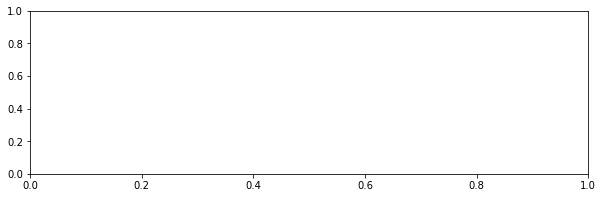

In [19]:
fig, ax = plt.subplots(figsize=[10,3])
ds = dset_dict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
if 'member_id' in ds.dims:
    ds = ds.isel(member_id=0)
pres = calc_PpCO2(ds)
#sigma2 = calc_sigma2(ds)
#meridionalsection(ax,pco2,clims=[0,2500],title=ds.attrs['intake_esm_dataset_key'])


#### I'm not sure why pressure is only being calculated for the first depth and none of the others

In [13]:
ds = dset_dict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
p = gsw.p_from_z(ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
p

<xarray.DataArray 'lev' (lev: 35, y: 180)>
array([[-2.52711839, -2.52711024, -2.52709394, ..., -2.52709394,
        -2.52711024, -2.52711839],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    time     int64 0
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    axis:         Z
    bounds:       lev_bnds
    description:  generic ocean model vertical coordinate (nondimensional or ...
    long_name:    ocean model level
    positive:     down
    units:        m

#### Obvi this result is unreliable as long as p is wrong

In [17]:
insitutemp = gsw.t_from_CT(ds['talk'], ds['thetao'], p)

IndexError: Index is not smaller than dimension 1 >= 1